# HANDWRITTEN EQUATION **SOLVER**

### **STEPS TAKEN:**

* Connecting the notebook to google docs, where we have the dataset
* Loading the dataset and importing the libraries (Importing necessary libraries as the code requires)
* Loading the images into an array
* Splitting the images for training and testing purpose
* Preprocessing the data
* Building the CNN model
* Training the data
* Saving the trained model
* Evaluating the model performance using test data, plotting the confusion matrix and heatmap
* Evaluating the model performance on sample images from the internet

### Equation solving:
* Importing the equation from the local drive
* Preprocessing the image and segregating individual digits and symbols
* Using the trained model, predicting each symbol
* Recombining the equation and solving it



### Mounting google drive and setting up data directory

In [ ]:
# Mount Google Drive to access the uploaded dataset
from google.colab import drive
drive.mount('/content/drive')

# Set the path to your dataset folder
data_dir = '/content/drive/My Drive/dataset'

Mounted at /content/drive


### Load images and assign labels


Loaded 7600 images with labels
Image shape: (32, 32)


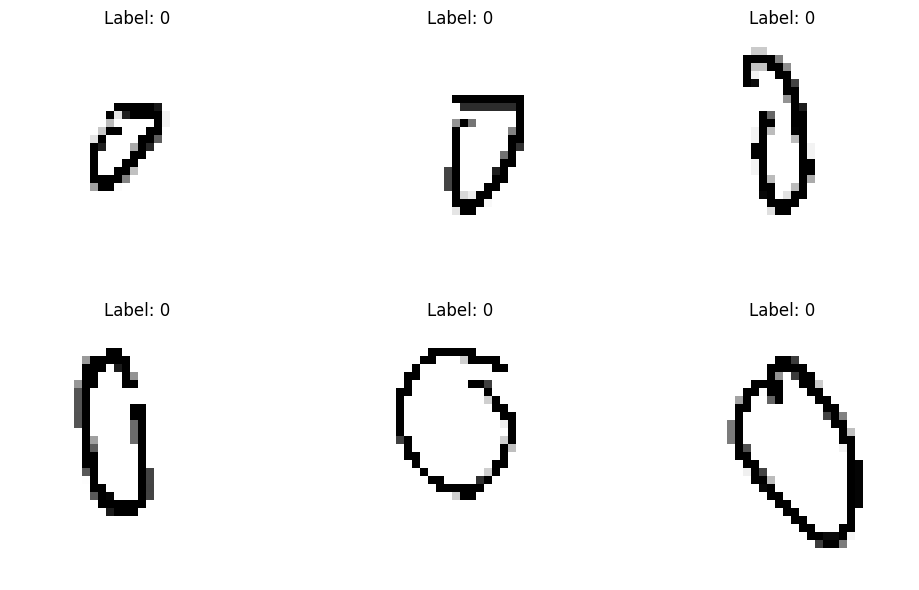

In [ ]:
from pathlib import Path
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

# Define image dimensions (32x32 for better quality compared to 28x28, but does not take too much computation)
IMG_SIZE = 32

# Label mapping from folder names to integer labels
label_mapping = {'0': 0, '1': 1, '2': 2, '3': 3, '4': 4, '5': 5, '6': 6, '7': 7, '8': 8, '9': 9, 'add': 10, 'div': 11, 'mul': 12, 'sub': 13}

# Initialize lists to hold images and labels
images = []
labels = []

# Iterate through the label mapping and load the images
for label, label_num in label_mapping.items():  # Where label is the class of the image, and label_num is the assigned integer
    label_folder_path = Path(data_dir) / label  # Using pathlib to create the path to the folder containing images for that label

    if label_folder_path.is_dir():  # Check if the path is a directory
        # Go through all files in the label's folder
        for image_file in label_folder_path.iterdir():  #folder.iterdir(): iterates over the files in the folder
            # Open the image directly
            img = Image.open(image_file)

            # Resize the image to the desired size
            resized_image = img.resize((IMG_SIZE, IMG_SIZE))

            # Convert the image to a numpy array and append it to the list
            images.append(np.array(resized_image))
            labels.append(label_num)

# Convert lists to numpy arrays
images = np.array(images)
labels = np.array(labels)

# Print out details of the dataset
print(f"Loaded {len(images)} images with labels")
print(f"Image shape: {images[0].shape}")

# Visualize a few images
plt.figure(figsize=(10, 6))
for i in range(min(6, len(images))):  # Display 6 images
    plt.subplot(2, 3, i + 1)
    plt.imshow(images[i], cmap='gray')
    plt.axis('off')
    plt.title(f"Label: {labels[i]}")
plt.tight_layout()
plt.show()


### Shuffle and split dataset
1. Normalize the image pixel values to the range [0, 1], which is a common practice for neural networks.
2. Shuffle the data to ensure randomness, so that the model sees diverse batches of data during training.
3. Split the dataset:
* 75% for training.
* 25% for a temporary set that will be split into:
 * 50% for validation (to tune the model).
 * 50% for testing (to evaluate the model after training).
4. Print the sizes of the resulting datasets to verify the split.

In [ ]:
from sklearn.utils import shuffle, train_test_split

# Normalize the images (scale the pixel values to [0, 1]) - This will make model training more stable.
images = images.astype('float32') / 255.0

# Shuffle the dataset to ensure randomness
images, labels = shuffle(images, labels, random_state=42)

# Split the dataset
# First, split into training (75%) and temp (25%)
X_train, X_temp, y_train, y_temp = train_test_split(images, labels, test_size=0.25, random_state=42)

# Then split the 30% temp into validation (15%) and test (15%)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Print dataset sizes to verify
print(f"Training set size: {X_train.shape[0]} images")
print(f"Validation set size: {X_val.shape[0]} images")
print(f"Test set size: {X_test.shape[0]} images")

Training set size: 5700 images
Validation set size: 950 images
Test set size: 950 images


## Data exploration

### Check label distribution

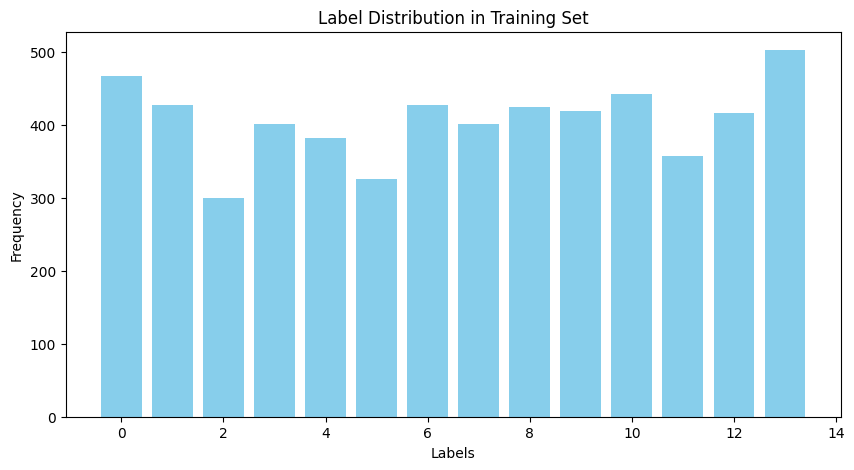

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Count occurrences of each label in the training set
unique, counts = np.unique(y_train, return_counts=True)
label_distribution = dict(zip(unique, counts))

# Plotting the label distribution
plt.figure(figsize=(10, 5))
plt.bar(label_distribution.keys(), label_distribution.values(), color='skyblue')
plt.title("Label Distribution in Training Set")
plt.xlabel("Labels")
plt.ylabel("Frequency")
plt.show()

### Visualise a few sample images
* to ensure images are correctly labelled and resized

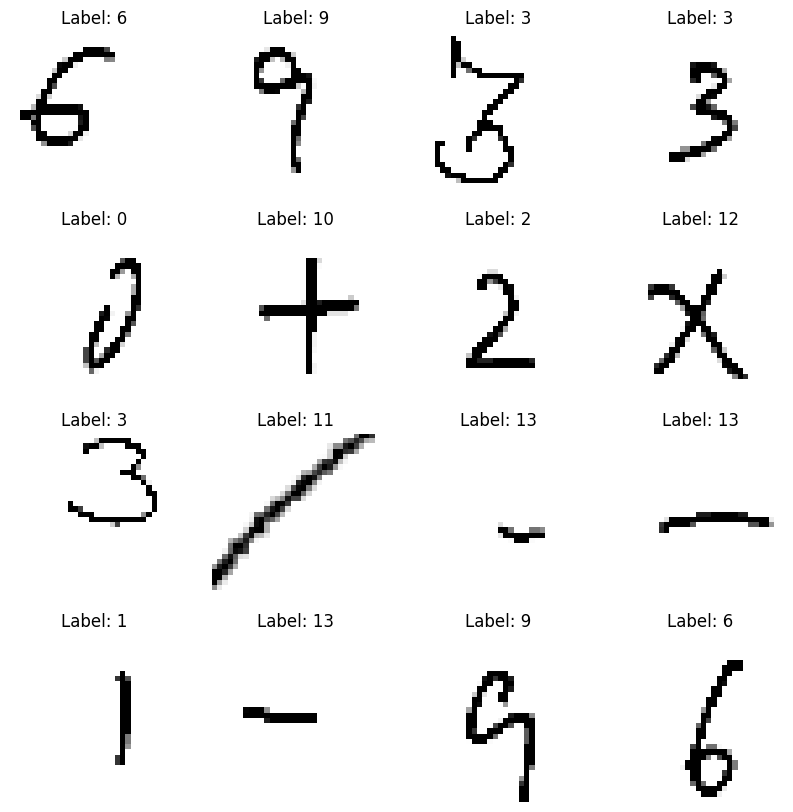

In [ ]:
# Plot a few random samples from the training set
plt.figure(figsize=(10, 10))
for i in range(16):  # Display 16 images in a 4x4 grid
    plt.subplot(4, 4, i + 1)
    index = np.random.randint(0, X_train.shape[0])
    plt.imshow(X_train[index], cmap='gray')
    plt.title(f"Label: {y_train[index]}")
    plt.axis('off')
plt.show()

### Basic image statistics

In [ ]:
# Print basic stats like mean and standard deviation
print(f"Mean pixel value (training set): {X_train.mean():.4f}") #.4f limits result to 4 decimal places
print(f"Standard deviation of pixel values (training set): {X_train.std():.4f}")

Mean pixel value (training set): 0.9413
Standard deviation of pixel values (training set): 0.2269


In [ ]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(5700, 32, 32)
(950, 32, 32)
(5700,)
(950,)


### Label encoding: (One hot encode)
* Label Encoding is a technique that converts categorical labels into numerical values, typically by assigning each category an integer.
* One-Hot Encoding is a more sophisticated technique used to convert categorical data into a binary matrix (or vector). Each category is represented as a binary vector where only one element is 1, and the rest are 0

In [ ]:
from tensorflow.keras.utils import to_categorical

y_train_encoded = to_categorical(y_train)
y_test_encoded = to_categorical(y_test)

# Check new shape
print("Encoded Labels Shape:", y_train_encoded.shape, y_test_encoded.shape)

Encoded Labels Shape: (5700, 14) (950, 14)


### Reshaping data for CNN

CNN expect a 3D input, so we add a single channel (for grayscale)

In [ ]:
# Adding a channel dimension
X_train_reshaped = X_train.reshape(-1, 32, 32, 1)
X_test_reshaped = X_test.reshape(-1, 32, 32, 1)

# Verify the shape
print("Training data shape:", X_train_reshaped.shape)
print("Test data shape:", X_test_reshaped.shape)

Training data shape: (5700, 32, 32, 1)
Test data shape: (950, 32, 32, 1)


## Building CNN Model
* Model Architecture Design:

1. Convolutional Layers:
Used padding='same' to maintain spatial dimensions after each convolution, ensuring edge information is preserved.
Selected two convolutional blocks with filters of 64 and 128 respectively to progressively extract and combine features from the images.

2. Batch Normalization: Applied batch normalization after each convolutional layer and dense layer to improve convergence, prevent vanishing or exploding gradients, and add slight regularization.

3. Pooling and Dropout Layers:
Inserted max pooling layers after each convolution block to downsample spatial dimensions and reduce the number of parameters.
Integrated dropout after each convolutional block and before the output to mitigate overfitting.

4. Dense Layers:
Used a fully connected layer with 1024 units to integrate features from convolutional layers. Applied dropout with a 50% rate for additional regularization.
Added a softmax output layer with 14 units (one for each class), converting the model's output to class probabilities.

* Model Compilation:
Compiled the model using the Adam optimizer for adaptive learning, categorical cross-entropy as the loss function (appropriate for multi-class classification), and accuracy as the evaluation metric.


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization

model = Sequential([
    # First Convolutional Block
    Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=(32, 32, 1)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.3),

    # Second Convolutional Block
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.3),

    # Flattening Layer
    Flatten(),

    # Dense Layers
    Dense(1024, activation='relu'),
    BatchNormalization(),
    Dropout(0.6),

    # Output Layer
    Dense(14, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)                    │ (None, 32, 32, 64)          │             640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 32, 32, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 16, 16, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 16, 16, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 8192)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1024)                │       8,389,632 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 1024)                │           4,096 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 14)                  │          14,350 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,483,342 (32.36 MB)

 Trainable params: 8,480,910 (32.35 MB)

 Non-trainable params: 2,432 (9.50 KB)

# Here is a detailed note on the model architecture:
## Sequential
A Sequential model refers to a neural network architecture where the layers are added in a sequential order. This means the output of one layer becomes the input of the next. It's called "sequential" because the data flows from the first layer to the last one without skipping or branching.

* ### First Convolutional Block:
 * 64: This is the number of filters (or feature maps). It defines how many different features the network should learn during this layer. The higher the number of filters, the more features the network learns, but it also increases computational complexity.
 * (3, 3): This is the size of the filter/kernel. The filter slides over the input image to perform convolution and extract features. A (3, 3) kernel means the filter is 3 pixels wide and 3 pixels tall.

 * activation='relu': ReLU (Rectified Linear Unit) is the activation function applied to the output of the convolution. It helps introduce non-linearity, which allows the network to learn complex patterns. ReLU is commonly used in CNNs because it helps introduce non-linearity to the model, which allows it to learn more complex patterns. The ReLU function sets all negative values to zero and keeps positive values unchanged.

 * padding='same': This padding option ensures that the output of the convolution layer has the same spatial dimensions as the input. Essentially, the filter is applied in such a way that it keeps the input size unchanged.
input_shape=(32, 32, 1): This defines the shape of the input data. The images are assumed to be 32x32 pixels and grayscale (1 channel). If the images were RGB, this would be (32, 32, 3).

 * BatchNormalization():
This layer normalizes the activations in the previous layer. It standardizes the inputs to a layer for each mini-batch, helping with faster training and reducing the chances of getting stuck in local minima. It helps stabilize and speed up the learning process.

 * MaxPooling2D((2, 2)):
This is a max-pooling layer that reduces the spatial dimensions (height and width) of the input. In this case, it performs a 2x2 pooling operation, which means it reduces the width and height of the feature map by a factor of 2. This operation keeps only the maximum value in each 2x2 grid, effectively downsampling the image while retaining important features.

 * Dropout(0.3):This layer randomly drops 30% of the neurons during training to prevent overfitting. By dropping connections randomly, the model is forced to generalize better, as it cannot rely too heavily on any one neuron.

* ### Second Convolutional Block:

 * Conv2D(128, (3, 3), activation='relu', padding='same'):
This layer is similar to the first convolutional layer, but with 128 filters instead of 64, allowing the network to learn more complex features at this stage.

 * BatchNormalization() and MaxPooling2D((2, 2)): These layers are identical to those in the first block, again normalizing the activations and performing max-pooling.

 * Dropout(0.3): Again, a dropout layer is added after the second convolutional block to prevent overfitting. 30% of neurons will be dropped.

* ### Flattening Layer:
 * Flatten(): After the convolutional and pooling layers, the data is still in the form of 2D feature maps. The Flatten() layer converts this 2D data into a 1D vector, making it compatible for the dense (fully connected) layers that follow. Essentially, it "flattens" the entire feature map into a single long vector.

* ### Dense Layers:
 * Dense(1024, activation='relu'): This is a fully connected layer with 1024 neurons. The number of neurons in the dense layer determines the number of features or hidden units the model has to work with.
The ReLU activation is applied to introduce non-linearity to the output of this layer.

 * BatchNormalization(): As with previous blocks, batch normalization is applied to this dense layer to stabilize and accelerate training.

 * Dropout(0.6): A dropout rate of 60% is applied to this layer, meaning 60% of the neurons in this layer will be randomly dropped during training to help prevent overfitting. This is a higher dropout rate, as dense layers are prone to overfitting due to their high number of parameters.

* ### Output Layer:
 * Dense(14, activation='softmax'): This is the output layer, where the network produces the final predictions.
14 represents the number of output classes (in this case, 14 classes). This is the final layer of the network, and its size matches the number of possible output classes for classification.

 * softmax activation: The softmax function converts the output logits (raw predictions) into probabilities. It squashes the outputs into a range between 0 and 1, and the sum of all the probabilities equals 1. This is ideal for multi-class classification problems.

## Compiling the Model:
* optimizer='adam': This specifies the Adam optimizer, which is an adaptive optimization algorithm that combines the advantages of two other popular optimizers: AdaGrad and RMSProp. It adapts the learning rate based on the gradients of the parameters and helps with faster convergence.

* loss='categorical_crossentropy': This is the loss function used for multi-class classification problems. Categorical cross-entropy measures the difference between the true class labels and the predicted probabilities (from softmax) and penalizes the model for incorrect predictions.

* metrics=['accuracy']: This defines the metric used to evaluate the model's performance during training. In this case, accuracy is used, which measures the percentage of correct predictions.

### Defining Callbacks

1. Learning Rate Scheduler (step_decay):
This function adjusts the learning rate at specified intervals. It’s defined to gradually reduce the learning rate as the training progresses, helping the model converge better. Lowering the learning rate in steps often helps stabilize the model’s performance by allowing smaller adjustments as training progresses.



2. Model Checkpoint (ModelCheckpoint):
This callback saves the model at regular intervals, specifically saving only the "best" model (determined by validation loss) during training. Using save_best_only=True with monitor='val_loss' ensures that only the model with the lowest validation loss is saved. This is helpful in retaining a model version with optimal generalization performance.



3. Early Stopping (EarlyStopping):
This callback stops training when the model’s performance on the validation set stops improving. It monitors the val_loss and will halt training if there’s no improvement after a certain patience period. This helps prevent overfitting by stopping the training process before the model starts to memorize the training data.



4. Reduce Learning Rate on Plateau (ReduceLROnPlateau):
This callback reduces the learning rate automatically when a metric (usually validation loss) stops improving for a specified number of epochs. By adjusting the learning rate dynamically based on performance, it allows the model to make finer adjustments when it reaches a plateau, helping it converge more effectively.

In [ ]:
from tensorflow.keras.callbacks import LearningRateScheduler, ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# Define Callbacks
# 1. Step Decay Learning Rate Scheduler
def step_decay(epoch):
    initial_lr = 0.001
    drop_rate = 0.5
    epochs_drop = 10
    lr = initial_lr * (drop_rate ** (epoch // epochs_drop))
    return lr

lr_scheduler = LearningRateScheduler(step_decay)

# 2. Model Checkpoint
checkpoint = ModelCheckpoint(
    'HandwrittenMathsmodel.keras', monitor='val_accuracy', save_best_only=True, mode='max', verbose=1
)

# 3. Early Stopping
early_stopping = EarlyStopping(
    monitor='val_accuracy', patience=15, restore_best_weights=True, verbose=1
)

# 4. Reduce Learning Rate on Plateau
reduce_lr = ReduceLROnPlateau(
    monitor='val_accuracy', factor=0.2, patience=6, min_lr=0.0001, verbose=1
)

# Combine Callbacks
callbacks = [lr_scheduler, checkpoint, early_stopping, reduce_lr]

### Augmenting images

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define ImageDataGenerator with minimal augmentations
datagen = ImageDataGenerator(
    zoom_range=0.15,             # Small zoom
    rotation_range=8,           # Small rotation
    width_shift_range=0.08,     # Small horizontal shift
    height_shift_range=0.08     # Small vertical shift
)


## Model training and saving:

In [ ]:
# Using augmented data in model training
history = model.fit(
    datagen.flow(X_train_reshaped, y_train_encoded, batch_size=32),
    validation_data=(X_test_reshaped, y_test_encoded),
    steps_per_epoch=len(X_train) // 32,
    epochs=100,
    callbacks=callbacks
)

#Saving the model
model.save('HandwrittenMathsmodel.keras')

Epoch 1/100
172/178 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.8002 - loss: 0.6867
Epoch 1: val_accuracy improved from -inf to 0.84211, saving model to HandwrittenMathsmodel.keras
178/178 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - accuracy: 0.8007 - loss: 0.6844 - val_accuracy: 0.8421 - val_loss: 0.6145 - learning_rate: 0.0010
Epoch 2/100
  1/178 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8750 - loss: 0.5675
Epoch 2: val_accuracy did not improve from 0.84211
178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 505us/step - accuracy: 0.8750 - loss: 0.5675 - val_accuracy: 0.8326 - val_loss: 0.6599 - learning_rate: 0.0010
Epoch 3/100
178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8315 - loss: 0.5565
Epoch 3: val_accuracy did not improve from 0.84211
178/178 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.8316 - loss: 0.5563 - val_accuracy: 0.5105 - val_loss: 3.4002 - learning_rate: 0.0010
Epoch 4/100
  1/178 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8125 - loss: 0.5459
Epoch 4: val_accuracy di

## Checking model performance:

In [ ]:
train_loss, train_accu = model.evaluate(X_train_reshaped, y_train_encoded)
test_loss, test_accu = model.evaluate(X_test_reshaped, y_test_encoded)
print("final train accuracy = {:.2f} , validation accuracy = {:.2f}".format(train_accu*100, test_accu*100))

179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9762 - loss: 0.0707
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9696 - loss: 0.1044
final train accuracy = 97.70 , validation accuracy = 96.74


### Confusion matrix

30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Confusion Matrix:
[[66  0  0  0  0  0  0  0  4  1  0  0  0  0]
 [ 0 71  0  0  1  0  0  1  1  0  0  0  0  0]
 [ 0  0 69  0  1  0  0  0  0  0  0  0  0  0]
 [ 0  0  0 67  0  0  0  0  1  0  0  0  0  0]
 [ 0  0  0  0 64  0  0  1  2  0  0  0  0  0]
 [ 0  0  0  0  0 63  1  0  1  0  0  0  0  0]
 [ 1  0  0  0  0  0 69  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0 56  3  0  0  0  0  0]
 [ 1  0  0  1  0  0  0  0 57  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  5 55  0  0  0  0]
 [ 0  1  0  0  0  0  0  0  0  0 74  0  0  0]
 [ 0  0  0  0  0  0  0  0  3  0  0 54  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0 76  0]
 [ 0  0  0  0  0  0  0  0  1  0  0  0  0 78]]


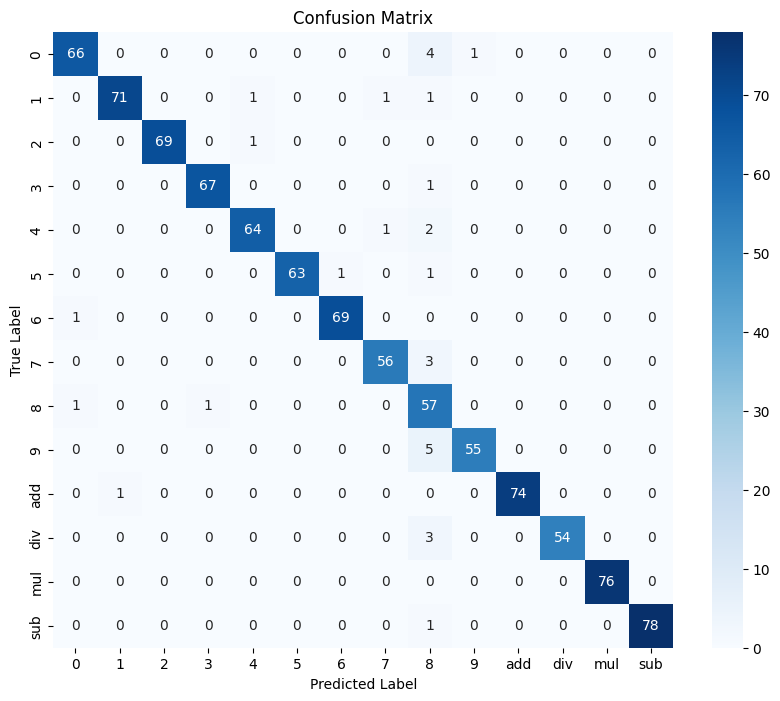

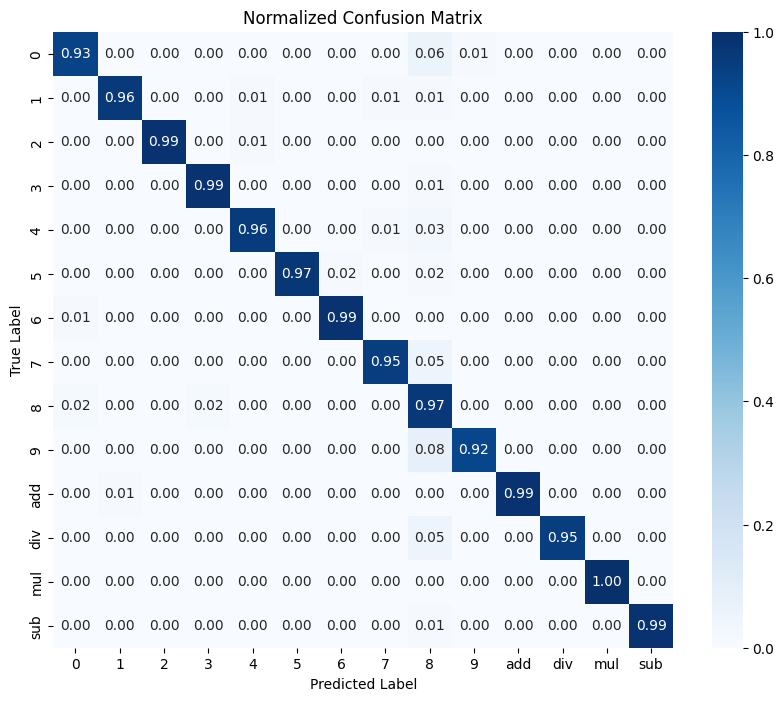

In [ ]:
# Import required libraries
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Make predictions on the test set
y_pred_probs = model.predict(X_test_reshaped)  # Get predicted probabilities
y_pred = np.argmax(y_pred_probs, axis=1)       # Convert probabilities to class predictions

# Convert the one-hot encoded true labels back to class labels
y_true = np.argmax(y_test_encoded, axis=1)

# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Print confusion matrix
print("Confusion Matrix:")
print(cm)

# Create a heatmap of the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_mapping.keys(), yticklabels=label_mapping.keys())
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Normalize the confusion matrix
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Create a heatmap for normalized confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues', xticklabels=label_mapping.keys(), yticklabels=label_mapping.keys())
plt.title('Normalized Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

## The model seems promising with high accuracy and correct predictions, We shall test the model now:

## Using images from web to test the predixtion accuracy of model on real world data

In [ ]:
import numpy as np
import requests
from PIL import Image
from io import BytesIO
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import img_to_array

### Loading and preprocessing image from url

In [ ]:
def load_and_preprocess_image(image_url, target_size=(32, 32)):
    # Fetch the image from URL
    response = requests.get(image_url)
    img = Image.open(BytesIO(response.content))

    # Convert to grayscale (if it's not already)
    img = img.convert('L')

    # Resize to the target size (32x32)
    img = img.resize(target_size)

    # Convert image to numpy array
    img_array = np.array(img)

    # Normalize the image (scale pixel values to [0, 1])
    img_array = img_array.astype('float32') / 255.0

    # Add an extra dimension for the "channels" (since the model expects 4D input)
    img_array = np.expand_dims(img_array, axis=-1)  # Shape becomes (32, 32, 1)

    # Add batch dimension (the model expects 4D input: (batch_size, height, width, channels))
    img_array = np.expand_dims(img_array, axis=0)  # Shape becomes (1, 32, 32, 1)

    return img_array


### Predict with model:

In [ ]:
def predict_image(model, image_url):
    # Load and preprocess the image
    img_array = load_and_preprocess_image(image_url)

    # Get the model's prediction
    prediction_probs = model.predict(img_array)

    # Get the predicted class (index of the maximum probability)
    predicted_class_index = np.argmax(prediction_probs)

    # Map predicted class index back to the label (using label_mapping_reverse)
    label_mapping_reverse = {v: k for k, v in label_mapping.items()}
    predicted_label = label_mapping_reverse[predicted_class_index] # Get the string label

    return predicted_label, prediction_probs


### Visualise test image and predictions

In [ ]:
def display_prediction(image_url, predicted_label, prediction_probs):
    # Load the image for display
    response = requests.get(image_url)
    img = Image.open(BytesIO(response.content))

    # Display the image
    plt.imshow(img)
    plt.axis('off')

    # Print prediction_probs and predicted_label for debugging
    print("Prediction Probs:", prediction_probs)
    print("Predicted Label:", predicted_label)

    # Get the integer index for predicted_label using label_mapping
    predicted_class_index = label_mapping[predicted_label]

    # Assuming prediction_probs is a 2D array with shape (1, num_classes)
    predicted_confidence = prediction_probs[0, predicted_class_index] * 100

    # Show the predicted label and confidence
    plt.title(f"Predicted Label: {predicted_label} ({predicted_confidence:.2f}% confidence)")
    plt.show()



### Testing Images

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Prediction Probs: [[2.1018120e-06 6.6094910e-04 4.8051925e-07 1.2373079e-07 7.9705456e-04
  2.0729350e-07 5.0495210e-06 2.3388486e-05 1.0752846e-04 1.9029398e-05
  1.1894246e-06 1.5692516e-06 9.9838138e-01 5.2195195e-09]]
Predicted Label: mul


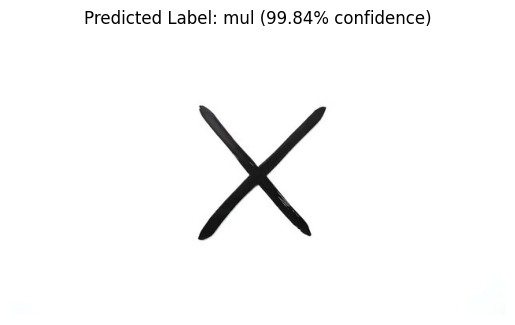

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Prediction Probs: [[7.0465787e-04 6.3849099e-09 2.1126402e-07 1.1618453e-05 1.2050964e-06
  1.7049054e-07 2.0953272e-04 2.0769500e-08 9.9843818e-01 6.3390727e-04
  1.1811662e-09 4.4410962e-07 1.9613040e-08 3.0229966e-10]]
Predicted Label: 8


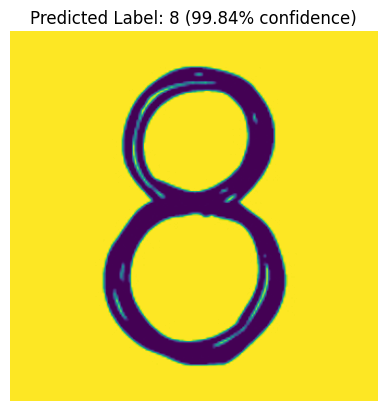

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Prediction Probs: [[1.5582797e-03 1.4071260e-04 7.5670850e-06 5.4926854e-03 1.8918101e-05
  9.8199987e-01 7.3585506e-03 9.1814254e-06 1.3376514e-03 1.5487121e-03
  2.1833239e-05 8.7401859e-05 2.6432181e-05 3.9212115e-04]]
Predicted Label: 5


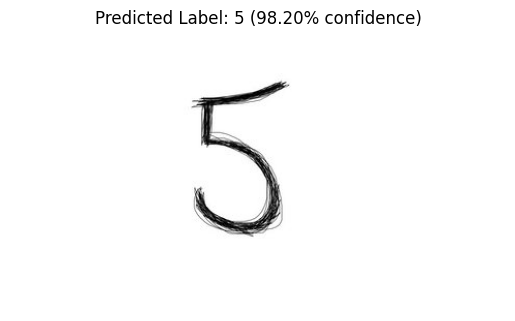

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Prediction Probs: [[3.6479303e-08 1.4997240e-04 4.5058814e-06 3.0537905e-08 5.2815873e-02
  5.2433272e-05 1.5684189e-05 1.0532080e-08 7.9021202e-06 2.9215355e-06
  9.4694823e-01 2.2206704e-07 4.5117979e-08 2.1496080e-06]]
Predicted Label: add


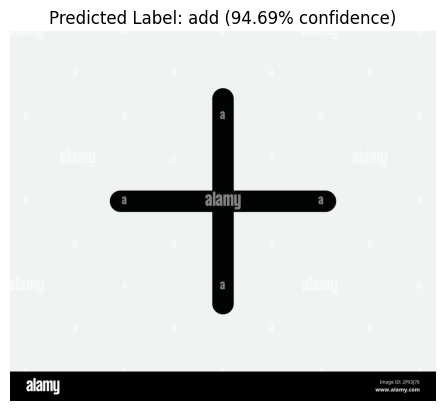

In [ ]:
# List of image URLs (replace with actual URLs of test images)
image_urls = [
              'https://t3.ftcdn.net/jpg/09/65/76/94/360_F_965769499_o8z6QfQJM4eJjnuI9qOnLLtT1icpapcq.jpg',
              'https://thumb.ac-illust.com/c3/c3f1db3e849f676df427981547fb8dcc_t.jpeg',
              'https://www.shutterstock.com/shutterstock/videos/23708545/thumb/1.jpg?ip=x480',
              'https://c8.alamy.com/comp/2PX3J70/plus-sign-cross-add-addition-math-mathematics-additional-black-and-white-line-icon-symbol-vector-artwork-clipart-illustration-2PX3J70.jpg'
]

# Test and display predictions for each image
for url in image_urls:
    predicted_label, prediction_probs = predict_image(model, url)
    display_prediction(url, predicted_label, prediction_probs)


## The predictions are accurate, We can move to next step

## Before that we shall save the model in our google drive for future use

In [ ]:
model_save_path = '/content/drive/My Drive/models/HandwrittenMathsmodel.keras'


In [ ]:
model.save(model_save_path) #model has been succesfully saved

# Importing the equation to solve
* We will import the image from our local storage
* We will then convert the image to binary (black and white)
* Then we will find ecah individual character in the image, and crop them
* Then we predict each symbol using our model
* After that we can reconstruct the entire equation and solve it

### Loading the image from local storage



Saving test equation epsilon.jpg to test equation epsilon.jpg


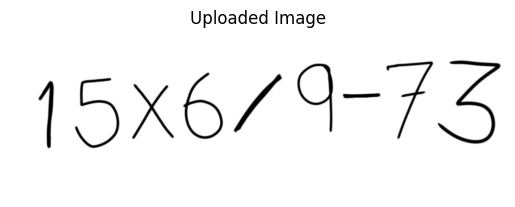

In [ ]:
from google.colab import files
import cv2
from matplotlib import pyplot as plt

# Upload the image file
uploaded = files.upload()

# Read the image (after uploading it)
image_path = next(iter(uploaded))  # Get the file name of the uploaded image
img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

# Display the image
plt.imshow(img, cmap='gray')
plt.title('Uploaded Image')
plt.axis('off')
plt.show()

## Image preprocessing and symbol segmentation
### Steps taken:
* We apply inverse binary thresholding to make the image black and white for easy contouring.
* We then find the contours of image for each symbol and sort them to preserve their order
* We then crop the symbols with their bounding rectangle and add padding around the box to prevent tight cropping along with noise reduction.
* We then dynamically apply padding to symbols to preserve their shape during resizing into an image of 32*32 pixels; symbols like 1 and - would be stretched and give inorrect outputs when reshaping if not dynamically padded
* We then correct the binarization from black backround and white symbol to white background and black symbol as the model has been trained on.
* These preprocessed images can be used by model to predict each symbol, and we store each predicted ouotput in a list, which can be later converted into a single equation to be solved using the inbuilt pyhton eval() function

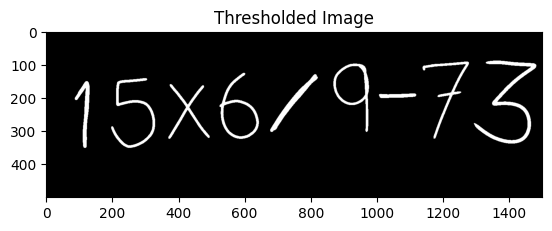

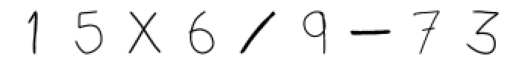

In [ ]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

def preprocess_and_segment_equation(img):
    # Apply inverse binary thresholding
    _, thresh_img = cv2.threshold(img, 150, 255, cv2.THRESH_BINARY_INV)
    '''
    This thresholding converts the image to black and white:
    - Pixels greater than 150 are set to black (0).
    - Pixels less than 150 are set to white (255).
    '''

    # Find contours of the symbols (individual characters or digits)
    contours, _ = cv2.findContours(thresh_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Sort contours from left to right (important for reconstructing the equation order)
    contours = sorted(contours, key=lambda ctr: cv2.boundingRect(ctr)[0])

    # List to store cropped and processed symbols
    cropped_symbols = []

    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        '''
        x, y: Coordinates of the top-left corner of the bounding box.
        w: The width of the bounding box.
        h: The height of the bounding box.
        '''
        # Adding padding around the bounding box to avoid tight cropping
        padding = 10
        x, y, w, h = x - padding, y - padding, w + 2 * padding, h + 2 * padding

        # Only consider contours that are large enough (filter out noise)
        if w > 20 and h > 20:
            # Crop the symbol from the thresholded image
            symbol = thresh_img[y:y+h, x:x+w]

            # Resize the symbol to 32x32 while maintaining aspect ratio (with padding)
            symbol_resized = resize_with_dynamic_padding(symbol, target_size=(32, 32))

            bin_corrected_symbols = cv2.bitwise_not(symbol_resized) #To correct the image binarization
            cropped_symbols.append(bin_corrected_symbols)
    return cropped_symbols, thresh_img


def resize_with_dynamic_padding(symbol, target_size=(32, 32)):
    """
    Resizes the symbol to fit within a 32x32 canvas while maintaining its aspect ratio.
    If the aspect ratio is different from 1:1, it pads the symbol to the center.
    """
    h, w = symbol.shape

    # If the symbol is taller than it is wide, resize based on height
    if h > w:
        scaling_factor = target_size[0] / h  # scale based on height
    else:
        scaling_factor = target_size[1] / w  # scale based on width

    # Calculate the new dimensions while maintaining the aspect ratio
    new_h = int(h * scaling_factor)
    new_w = int(w * scaling_factor)

    # Resize the symbol to the calculated dimensions
    resized_symbol = cv2.resize(symbol, (new_w, new_h), interpolation=cv2.INTER_AREA)

    # Create a blank (black) canvas of the target size (black background)
    padded_symbol = np.zeros(target_size, dtype=np.uint8)  # Black background

    # Calculate the top-left corner where the resized symbol should be placed
    top = (target_size[0] - new_h) // 2
    left = (target_size[1] - new_w) // 2

    # Place the resized symbol onto the canvas (centered)
    padded_symbol[top:top+new_h, left:left+new_w] = resized_symbol

    return padded_symbol


# Example of running the preprocessing
cropped_symbols, thresh_img = preprocess_and_segment_equation(img)

# Display the thresholded image
plt.imshow(thresh_img, cmap='gray')
plt.title('Thresholded Image')
plt.show()

# Display the cropped symbols
for i, symbol in enumerate(cropped_symbols):
    plt.subplot(1, len(cropped_symbols), i+1)
    plt.imshow(symbol, cmap='gray')
    plt.axis('off')
plt.show()


### Predicting each symbol

In [ ]:
from tensorflow.keras.models import load_model
import numpy as np

# # Mount Google Drive to access the uploaded dataset
# from google.colab import drive
# drive.mount('/content/drive')

# # Load the trained model (assuming it's already saved in Google Drive)
model = load_model('/content/drive/My Drive/models/HandwrittenMathsmodel.keras')


# Define the mapping from label indices to the actual symbols (digits, operators)
label_mapping = {
    '0': 0, '1': 1, '2': 2, '3': 3, '4': 4, '5': 5, '6': 6, '7': 7, '8': 8, '9': 9,
    'add': 10, 'div': 11, 'mul': 12, 'sub': 13
}

# Reverse the label mapping for easy lookup
label_mapping_reverse = {v: k for k, v in label_mapping.items()}

def predict_symbol(symbol_image):
    # Normalize and reshape the symbol image to fit the model input shape
    symbol_image = symbol_image.astype('float32') / 255.0  # Normalize
    symbol_image = np.expand_dims(symbol_image, axis=-1)  # Add channel dimension
    symbol_image = np.expand_dims(symbol_image, axis=0)  # Add batch dimension

    # Predict using the model
    prediction_probs = model.predict(symbol_image)
    predicted_class_index = np.argmax(prediction_probs)  # Get the predicted class (symbol)

    # Get the corresponding label (digit/operator)
    predicted_label = label_mapping_reverse[predicted_class_index]

    return predicted_label

# Predict each symbol
predicted_equation = []
for symbol in cropped_symbols:
    predicted_label = predict_symbol(symbol)
    predicted_equation.append(predicted_label)

# Output the predicted equation
print("Predicted Equation:", ''.join(predicted_equation))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 286ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Predicted Equation: 15mul6div9sub73


### The prediction is correct, we can move to next step


## Parsing the equation and solving it:
* We stitch the individual elements that were predicted into one single string
* We convert symbol classes into individual symbols (for example 'add'-> '+')
* We solve the equation using built in "eval" function

In [ ]:
def parse_and_solve(predicted_list):
    # Define a mapping for the operator words to symbols
    operator_map = {
        'add': '+',
        'mul': '*',
        'div': '/',
        'sub': '-'
    }

    # Initialize an empty string to hold the equation
    equation = ""

    # Stitch the predicted symbols and operators into a valid equation
    for item in predicted_list:
        if item in operator_map:
            # Replace operators with their symbols
            equation += operator_map[item]
        else:
            # Add the digits as they are
            equation += item

    # Print the stitched equation
    print(f"Equation: {equation}")

    try:
        # Evaluate the equation safely
        result = eval(equation)
        print(f"Solution: {result}")
        return equation, result  # Return both the equation and the result
    except Exception as e:
        print(f"Error evaluating the equation: {e}")
        return equation, None  # Return the equation and None if there was an error


**Now that the function is defined, we pass our predicted equation into it**

In [ ]:
parse_and_solve(predicted_equation)


Equation: 15*6/9-73
Solution: -63.0


-63.0

#Creating a user interface for better user experience:

### Step 1, compiling all the boxes in the input section into one

Saving test equation gamma.jpg to test equation gamma (1).jpg


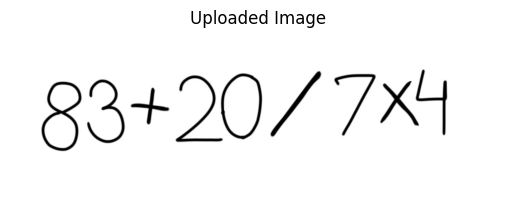

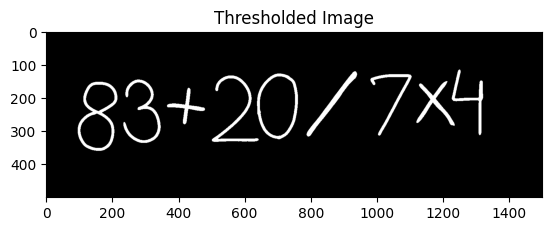

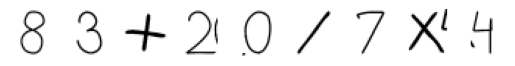

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 288ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Equation: 83+20/7*4
Solution: 94.42857142857143


94.42857142857143

In [ ]:
from google.colab import files
import cv2
from matplotlib import pyplot as plt
import numpy as np
from tensorflow.keras.models import load_model

# Upload the image file
uploaded = files.upload()

# Read the image (after uploading it)
image_path = next(iter(uploaded))  # Get the file name of the uploaded image
img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

# Display the image
plt.imshow(img, cmap='gray')
plt.title('Uploaded Image')
plt.axis('off')
plt.show()

def preprocess_and_segment_equation(img):
    # Apply inverse binary thresholding
    _, thresh_img = cv2.threshold(img, 150, 255, cv2.THRESH_BINARY_INV)
    '''
    This thresholding converts the image to black and white:
    - Pixels greater than 150 are set to black (0).
    - Pixels less than 150 are set to white (255).
    '''

    # Find contours of the symbols (individual characters or digits)
    contours, _ = cv2.findContours(thresh_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Sort contours from left to right (important for reconstructing the equation order)
    contours = sorted(contours, key=lambda ctr: cv2.boundingRect(ctr)[0])

    # List to store cropped and processed symbols
    cropped_symbols = []

    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        '''
        x, y: Coordinates of the top-left corner of the bounding box.
        w: The width of the bounding box.
        h: The height of the bounding box.
        '''
        # Adding padding around the bounding box to avoid tight cropping
        padding = 10
        x, y, w, h = x - padding, y - padding, w + 2 * padding, h + 2 * padding

        # Only consider contours that are large enough (filter out noise)
        if w > 20 and h > 20:
            # Crop the symbol from the thresholded image
            symbol = thresh_img[y:y+h, x:x+w]

            # Resize the symbol to 32x32 while maintaining aspect ratio (with padding)
            symbol_resized = resize_with_dynamic_padding(symbol, target_size=(32, 32))

            bin_corrected_symbols = cv2.bitwise_not(symbol_resized) #To correct the image binarization
            cropped_symbols.append(bin_corrected_symbols)
    return cropped_symbols, thresh_img

def resize_with_dynamic_padding(symbol, target_size=(32, 32)):
    """
    Resizes the symbol to fit within a 32x32 canvas while maintaining its aspect ratio.
    If the aspect ratio is different from 1:1, it pads the symbol to the center.
    """
    h, w = symbol.shape

    # If the symbol is taller than it is wide, resize based on height
    if h > w:
        scaling_factor = target_size[0] / h  # scale based on height
    else:
        scaling_factor = target_size[1] / w  # scale based on width

    # Calculate the new dimensions while maintaining the aspect ratio
    new_h = int(h * scaling_factor)
    new_w = int(w * scaling_factor)

    # Resize the symbol to the calculated dimensions
    resized_symbol = cv2.resize(symbol, (new_w, new_h), interpolation=cv2.INTER_AREA)

    # Create a blank (black) canvas of the target size (black background)
    padded_symbol = np.zeros(target_size, dtype=np.uint8)  # Black background

    # Calculate the top-left corner where the resized symbol should be placed
    top = (target_size[0] - new_h) // 2
    left = (target_size[1] - new_w) // 2

    # Place the resized symbol onto the canvas (centered)
    padded_symbol[top:top+new_h, left:left+new_w] = resized_symbol

    return padded_symbol

# Example of running the preprocessing
cropped_symbols, thresh_img = preprocess_and_segment_equation(img)

# Display the thresholded image
plt.imshow(thresh_img, cmap='gray')
plt.title('Thresholded Image')
plt.show()

# Display the cropped symbols
for i, symbol in enumerate(cropped_symbols):
    plt.subplot(1, len(cropped_symbols), i+1)
    plt.imshow(symbol, cmap='gray')
    plt.axis('off')
plt.show()

# Mount Google Drive to access the uploaded dataset
from google.colab import drive
drive.mount('/content/drive')

# Load the trained model (assuming it's already saved in Google Drive)
model = load_model('/content/drive/My Drive/models/HandwrittenMathsmodel.keras')

# Define the mapping from label indices to the actual symbols (digits, operators)
label_mapping = {
    '0': 0, '1': 1, '2': 2, '3': 3, '4': 4, '5': 5, '6': 6, '7': 7, '8': 8, '9': 9,
    'add': 10, 'div': 11, 'mul': 12, 'sub': 13
}

# Reverse the label mapping for easy lookup
label_mapping_reverse = {v: k for k, v in label_mapping.items()}

def predict_symbol(symbol_image):
    # Normalize and reshape the symbol image to fit the model input shape
    symbol_image = symbol_image.astype('float32') / 255.0  # Normalize
    symbol_image = np.expand_dims(symbol_image, axis=-1)  # Add channel dimension
    symbol_image = np.expand_dims(symbol_image, axis=0)  # Add batch dimension

    # Predict using the model
    prediction_probs = model.predict(symbol_image)
    predicted_class_index = np.argmax(prediction_probs)  # Get the predicted class (symbol)

    # Get the corresponding label (digit/operator)
    predicted_label = label_mapping_reverse[predicted_class_index]

    return predicted_label

# Predict each symbol
predicted_equation = []
for symbol in cropped_symbols:
    predicted_label = predict_symbol(symbol)
    predicted_equation.append(predicted_label)

def parse_and_solve(predicted_list):
    # Define a mapping for the operator words to symbols
    operator_map = {
        'add': '+',
        'mul': '*',
        'div': '/',
        'sub': '-'
    }


    # Initialize an empty string to hold the equation
    equation = ""

    # Stitch the predicted symbols and operators into a valid equation
    for item in predicted_list:
        if item in operator_map:
            # Replace operators with their symbols
            equation += operator_map[item]
        else:
            # Add the digits as they are
            equation += item

    # Print the stitched equation
    print(f"Equation: {equation}")

    try:
        # Evaluate the equation safely
        result = eval(equation)
        print(f"Solution: {result}")
        return result
    except Exception as e:
        print(f"Error evaluating the equation: {e}")
        return None

parse_and_solve(predicted_equation)


In [ ]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
import ipywidgets as widgets
from IPython.display import display

# Create widgets
upload_button = widgets.FileUpload(accept='image/*', multiple=False)
evaluate_button = widgets.Button(description="Evaluate Equation", disabled=True)
reset_button = widgets.Button(description="Reset", disabled=False)

# Style the buttons with colors
upload_button.style.button_color = '#FFD700'
evaluate_button.style.button_color = 'gray'
reset_button.style.button_color = 'red'

# Arrange buttons side by side using HBox
button_box = widgets.HBox([upload_button, evaluate_button, reset_button])

output = widgets.Output()

# Display widgets
display(button_box, output)

# Function to handle image upload
def on_upload_change(change):
    # This function will be triggered when a file is uploaded
    uploaded_file = list(upload_button.value.values())[0]
    img_data = uploaded_file['content']
    img = np.array(bytearray(img_data), dtype=np.uint8)
    img = cv2.imdecode(img, cv2.IMREAD_GRAYSCALE)

    # Display the uploaded image
    with output:
        plt.imshow(img, cmap='gray')
        plt.title("Uploaded Image")
        plt.axis('off')
        plt.show()

    # Store the image for later processing
    globals()['img'] = img

    # Change button color after upload
    upload_button.style.button_color = 'green'  # Change color of upload button
    evaluate_button.disabled = False  # Enable evaluate button
    evaluate_button.style.button_color = 'green'  # Change color of evaluate button

# Function to evaluate the equation
def on_evaluate_button_clicked(b):
    if 'img' not in globals():
        with output:
            print("Please upload an image first!")
        return

    # Preprocess the image and extract symbols
    cropped_symbols, _ = preprocess_and_segment_equation(img)  # Unpack the tuple here

    # Predict each symbol and construct the equation
    predicted_equation = []
    for symbol in cropped_symbols:
        predicted_label = predict_symbol(symbol)
        predicted_equation.append(predicted_label)

    # Parse and solve the equation
    equation, result = parse_and_solve(predicted_equation)

    with output:
        if equation:
            print(f"Equation: {equation}")
            print(f"Solution: {result}")
        else:
            print(f"Error: {result}")

# Function to reset the interface
def on_reset_button_clicked(b):
    # Reset the buttons and output
    upload_button.value.clear()  # Clear uploaded file
    upload_button.style.button_color = '#FFD700'  # Reset button color
    evaluate_button.disabled = True  # Disable evaluate button
    evaluate_button.style.button_color = 'gray'  # Reset evaluate button color
    reset_button.style.button_color = 'red'  # Reset reset button color
    output.clear_output()  # Clear output

# Link functions to the widgets
upload_button.observe(on_upload_change, names='value')
evaluate_button.on_click(on_evaluate_button_clicked)
reset_button.on_click(on_reset_button_clicked)


Output()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Equation: 1+2-3*4/5
Solution: 0.6000000000000001
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Equation: 67+24-12*3
Solution: 55


### What next?
There are many steps we can do after this,
* We can make a mobile application with an interactive UI with camera access to directly take photograph of the equation instead of manually selecting image from our local drive or we can integrate a "whiteboard" that allows user to write directly on the screen of the device.
* In input image preprocessing we can record positions of each symbols with respect to each other, this way we can use **exponents** and use variable **x** taking use of the similarity between x and multiplication operator, while using the same model
* We can use powerful python libraries like **SymPy** or API's like **WolframAlpha** for solving complex equations which can't be solved using eval() function alone, and possibly giving a step by step solution
* Using retraining or fine-tuning or transfer learning, we can make the model more robust and have more classes for different useful mathematic operations, such as decimals, parentheses, variables, integrals, trigonometric symbols, etc.

## So we have decided to try and incorporate exponents and variable x support
(Currently in development, please ignore)

### Proposed function for exponent recognition (not completed)

In [ ]:
# def detect_exponent(symbols, height_threshold=10, horizontal_threshold=15):
#     exponent_indices = []  # List to store the indices of exponents

#     for i in range(1, len(symbols)):  # Start from 1 because we compare with the previous symbol
#         base = symbols[i - 1]
#         exponent = symbols[i]

#         x_base, y_base, w_base, h_base = cv2.boundingRect(base)
#         x_exp, y_exp, w_exp, h_exp = cv2.boundingRect(exponent)

#         # Calculate the bottom edge of the bounding box for both base and exponent
#         bottom_base = y_base + h_base
#         bottom_exp = y_exp + h_exp

#         # Check if the second symbol (potential exponent) is above the first symbol (base)
#         if (bottom_exp < y_base) and (abs(bottom_exp - bottom_base) > height_threshold) and (abs(x_exp - x_base) < horizontal_threshold):
#             # If the vertical offset from the base bottom is large enough, it's an exponent
#             exponent_indices.append(i)  # Store the index of the exponent

#     return exponent_indices


## Editing the parsing and solve part to incorporate variable 'x' as well using basic logic (not completed)

In [ ]:
# def parse_and_solve(predicted_list):  # predicted_list contains the list of all predictions done by the model, which is sorted according to the order in the equation
#     # Define a mapping for the operator words to symbols
#     operator_map = {
#         'add': '+',
#         'mul': '*',
#         'div': '/',
#         'sub': '-'
#     }

#     # Initialize an empty string to hold the equation
#     equation = ""

#     # Loop through the predicted list and apply context-based logic for 'mul' (which could be 'x' or '*')
#     for i, item in enumerate(predicted_list):

#         if item == 'mul':  # We have a 'mul' prediction, decide if it's '*' or 'x'
#             # Check if the next symbol is a digit or another operator
#             if i + 1 < len(predicted_list):
#                 next_item = predicted_list[i + 1]
#                 if next_item.isdigit():  # If next item is a digit, treat 'mul' as '*'
#                     equation += '*'  # Multiplication operator
#                 else:
#                     equation += 'x'  # Treat 'mul' as the variable 'x'
#             else:
#                 # If it's the last symbol, assume 'mul' is 'x' (variable)
#                 equation += 'x'

#         elif item in operator_map:
#             # Replace operators with their symbols
#             equation += operator_map[item]
#         else:
#             # Add the digits or other symbols as they are
#             equation += item

#     # Print the stitched equation
#     print(f"Equation: {equation}")

#     try:
#         # Evaluate the equation safely
#         result = eval(equation)
#         print(f"Solution: {result}")
#         return result
#     except Exception as e:
#         print(f"Error evaluating the equation: {e}")
#         return None


## Nex steps are incorporating essential symbols we use daily, the symbols planned are: (not completed)
> =,(),".",y

> So onto search of dataset we go!!!!